In [66]:
# imports
import pandas as pd
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.stats as sst
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Notebook variables
SEED_VALUE = 72
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

DEPTH = 5
ESTIMATORS = 5

trainDataPath = "../input/train.csv"
testDataPath = "../input/test.csv"

outputPath = "../output/submission-01.csv"


In [68]:
# Functions

# Function for comparing different approaches
def score_gradientboosting_model(X_train, X_valid, y_train, y_valid, n_estimators=200, max_depth=20):
    model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=SEED_VALUE, max_depth=max_depth)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds), accuracy_score(y_valid, preds)

def score_gradientboosting(X_train, X_valid, y_train, y_valid, params):
    scores = []

    for e in params["n_estimators"]:
      for d in params["depth"]:
        mae, accuracy = score_gradientboosting_model(X_train, X_valid, y_train, y_valid, n_estimators=e, max_depth=d)

        scores.append(
          {
            "type": "GradientBoostingClassifier",
            "mae": mae,
            "accuracy": accuracy,
            "estimators": e,
            "depth": d
          }
        )

    return scores


def score_randomforest_model(X_train, X_valid, y_train, y_valid, n_estimators=200, max_depth=20):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=SEED_VALUE, max_depth=max_depth)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds), accuracy_score(y_valid, preds)

def score_randomforest(X_train, X_valid, y_train, y_valid, params):
    scores = []

    for e in params["n_estimators"]:
      for d in params["depth"]:
        mae, accuracy = score_randomforest_model(X_train, X_valid, y_train, y_valid, n_estimators=e, max_depth=d)

        scores.append(
          {
            "type": "RandomForestClassifier",
            "mae": mae,
            "accuracy": accuracy,
            "estimators": e,
            "depth": d
          }
        )

    return scores

def score_adaboost_model(X_train, X_valid, y_train, y_valid):
    model = AdaBoostClassifier()
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds), accuracy_score(y_valid, preds)

def score_adaboost(X_train, X_valid, y_train, y_valid, params):
    scores = []

    mae, accuracy = score_adaboost_model(X_train, X_valid, y_train, y_valid)

    scores.append(
      {
        "type": "AdaBoostClassifier",
        "mae": mae,
        "accuracy": accuracy
      }
    )

    return scores

def score_decisiontree_model(X_train, X_valid, y_train, y_valid, max_depth=20):
    model = DecisionTreeClassifier(random_state=SEED_VALUE, max_depth=max_depth)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds), accuracy_score(y_valid, preds)

def score_decisiontree(X_train, X_valid, y_train, y_valid, params):
    scores = []

    for d in params["depth"]:
      mae, accuracy = score_decisiontree_model(X_train, X_valid, y_train, y_valid, max_depth=d)

      scores.append(
        {
          "type": "DecisionTreeClassifier",
          "mae": mae,
          "accuracy": accuracy,
          "depth": d
        }
      )

    return scores

def score_extratrees_model(X_train, X_valid, y_train, y_valid, n_estimators=200, max_depth=20):
    model = ExtraTreesClassifier(n_estimators=n_estimators, random_state=SEED_VALUE, max_depth=max_depth)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds), accuracy_score(y_valid, preds)

def score_extratrees(X_train, X_valid, y_train, y_valid, params):
    scores = []

    for e in params["n_estimators"]:
      for d in params["depth"]:
        mae, accuracy = score_extratrees_model(X_train, X_valid, y_train, y_valid, n_estimators=e, max_depth=d)

        scores.append(
          {
            "type": "ExtraTreesClassifier",
            "mae": mae,
            "accuracy": accuracy,
            "estimators": e,
            "depth": d
          }
        )

    return scores

def score_lsvc_model(X_train, X_valid, y_train, y_valid):
    model = LinearSVC(max_iter=10000)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds), accuracy_score(y_valid, preds)

def score_lsvc(X_train, X_valid, y_train, y_valid, params):
    scores = []

    mae, accuracy = score_lsvc_model(X_train, X_valid, y_train, y_valid)

    scores.append(
      {
        "type": "LinearSVC",
        "mae": mae,
        "accuracy": accuracy
      }
    )

    return scores

def create_homeplanet_bins(data):
    binData = data.copy()

    binData.loc[binData["HomePlanet"].isna(), "HomePlanet"] = "Unknown"

    binData["f_HomePlanet"] = binData["HomePlanet"]

    binData = pd.get_dummies(data = binData, columns = ["f_HomePlanet"], prefix = ["f_HomePlanet"])

    return binData

def create_idgroup_bins(data):
    binData = data.copy()

    binData["f_GroupId"] = binData.apply(lambda row: row.name.split("_")[0], axis=1)
    binData["f_GroupCount"] = binData.groupby(["f_GroupId"])["f_GroupId"].transform("count")
    
    binData["f_GroupAlone"] = 1
    binData.loc[binData["f_GroupCount"] > 1, "f_GroupAlone"] = 0

    binData["f_LargeGroup"] = 0
    binData.loc[binData["f_GroupCount"] > 3, "f_LargeGroup"] = 1

    return binData

def create_cabin_features(data):
    binData = data.copy()

    binData["Cabin"] = binData["Cabin"].fillna("U/U/U")
    binData["f_DeckTemp"] = binData.apply(lambda row: row["Cabin"].split("/")[0], axis=1)
    binData["f_CabinNumber"] = binData.apply(lambda row: row["Cabin"].split("/")[1], axis=1)
    binData["f_SideTemp"] = binData.apply(lambda row: row["Cabin"].split("/")[2], axis=1)

    binData["f_Deck"] = binData["f_DeckTemp"]
    binData = pd.get_dummies(data = binData, columns = ["f_DeckTemp"], prefix = ["f_Deck"])
    
    binData["f_Side"] = binData["f_SideTemp"]
    binData = pd.get_dummies(data = binData, columns = ["f_SideTemp"], prefix = ["f_Side"])

    return binData

def create_destination_bins(data):
    binData = data.copy()

    binData.loc[binData["Destination"].isna(), "Destination"] = "Unknown"
    binData["f_HomeDest"] = binData["HomePlanet"] + "_" + binData["Destination"]

    return binData

def create_age_bins(data):
    binData = data.copy()

    binData.loc[binData["Age"] >= 0, "f_Age"] = 0
    binData.loc[binData["Age"] > 15, "f_Age"] = 1
    binData.loc[binData["Age"] > 30, "f_Age"] = 2
    binData.loc[binData["Age"] > 45, "f_Age"] = 3
    binData.loc[binData["Age"] > 60, "f_Age"] = 4
    binData.loc[binData["Age"] > 75, "f_Age"] = 5

    binData["f_Young"] = 0
    binData.loc[binData["Age"] < 15, "f_Young"] = 1

    return binData

def create_vip_bins(data):
    binData = data.copy()

    binData["f_vip"] = 0

    binData.loc[binData["VIP"].isna(), "f_vip"] = 2
    binData.loc[(binData["VIP"] == True), "f_vip"] = 1

    return binData

def create_spend_features(data):
    binData = data.copy()

    spendFeatures = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    outsideSpendFeatures = ["FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

    #binData["f_totalspend"] = binData[spendFeatures].sum(axis=1)
    binData["f_outsidespend"] = binData[outsideSpendFeatures].sum(axis=1)

    binData.loc[binData[spendFeatures].sum(axis=1) == 0, "f_totalspend"] = 0
    binData.loc[binData[spendFeatures].sum(axis=1) > 0, "f_totalspend"] = 1
    binData.loc[binData[spendFeatures].sum(axis=1) > 750, "f_totalspend"] = 2
    binData["f_totalspend"] = binData["f_totalspend"].fillna(3)

    binData.loc[binData["RoomService"] == 0, "f_RoomService"] = 0
    binData.loc[binData["RoomService"] > 0, "f_RoomService"] = 1
    binData.loc[binData["RoomService"] > 100, "f_RoomService"] = 2
    binData["f_RoomService"] = binData["f_RoomService"].fillna(3)

    binData.loc[binData["FoodCourt"] == 0, "f_FoodCourt"] = 0
    binData.loc[binData["FoodCourt"] > 0, "f_FoodCourt"] = 1
    binData.loc[binData["FoodCourt"] > 100, "f_FoodCourt"] = 2
    binData["f_FoodCourt"] = binData["f_FoodCourt"].fillna(3)

    binData.loc[binData["ShoppingMall"] == 0, "f_ShoppingMall"] = 0
    binData.loc[binData["ShoppingMall"] > 0, "f_ShoppingMall"] = 1
    binData.loc[binData["ShoppingMall"] > 100, "f_ShoppingMall"] = 2
    binData["f_ShoppingMall"] = binData["f_ShoppingMall"].fillna(3)

    binData.loc[binData["Spa"] == 0, "f_Spa"] = 0
    binData.loc[binData["Spa"] > 0, "f_Spa"] = 1
    binData.loc[binData["Spa"] > 100, "f_Spa"] = 2
    binData["f_Spa"] = binData["f_Spa"].fillna(3)

    binData.loc[binData["VRDeck"] == 0, "f_VRDeck"] = 0
    binData.loc[binData["VRDeck"] > 0, "f_VRDeck"] = 1
    binData.loc[binData["VRDeck"] > 100, "f_VRDeck"] = 2
    binData["f_VRDeck"] = binData["f_VRDeck"].fillna(3)

    binData["f_ZeroSpend"] = 0
    binData.loc[binData["f_totalspend"] == 0, "f_ZeroSpend"] = 1

    return binData

def create_cryo_bins(data):
    binData = data.copy()

    binData["f_Cryo"] = 0

    binData.loc[binData["CryoSleep"].isna(), "f_Cryo"] = 2
    binData.loc[(binData["CryoSleep"] == True), "f_Cryo"] = 1

    # We assume that anyone that was unknown and didn't spend any money was in cryo
    # We assume that anyone that was unknown and did spend money was not in cryo
    binData.loc[(binData["f_Cryo"] == 2) & (binData["f_totalspend"] == 0), "f_Cryo"] = 1
    binData.loc[(binData["f_Cryo"] == 2) & (binData["f_totalspend"] > 0), "f_Cryo"] = 0

    return binData

def create_features(data):
  featureData = data.copy()

  featureData = create_homeplanet_bins(featureData)
  featureData = create_idgroup_bins(featureData)
  featureData = create_cabin_features(featureData)
  featureData = create_destination_bins(featureData)
  featureData = create_age_bins(featureData)
  featureData = create_vip_bins(featureData)
  featureData = create_spend_features(featureData)
  featureData = create_cryo_bins(featureData)

  return featureData

def score_models(X_train, X_valid, y_train, y_valid):
  randomForestParams = {
    "n_estimators": [5, 10, 25, 50, 100],
    "depth": [1, 5, 10, 20]
  }

  gradientBoostingParams = {
    "n_estimators": [5, 10, 25, 50, 100],
    "depth": [1, 5, 10, 20]
  }

  decisionTreeParams = {
    "depth": [1, 5, 10, 20, 50, 100]
  }

  extraTreesParams = {
    "n_estimators": [5, 10, 25, 50, 100, 200, 500, 100],
    "depth": [1, 5, 10, 20, 50, 100]
  }

  linearSVCParams = {}

  scores = []
  scores = scores + (score_gradientboosting(X_train, X_valid, y_train, y_valid, gradientBoostingParams))
  scores = scores + (score_randomforest(X_train, X_valid, y_train, y_valid, randomForestParams))
  scores = scores + (score_decisiontree(X_train, X_valid, y_train, y_valid, decisionTreeParams))
  scores = scores + (score_extratrees(X_train, X_valid, y_train, y_valid, extraTreesParams))
  scores = scores + (score_lsvc(X_train, X_valid, y_train, y_valid, linearSVCParams))
  scores = scores + (score_adaboost(X_train, X_valid, y_train, y_valid, {}))

  return scores


In [7]:
# Load initial data

rawData = pd.read_csv(trainDataPath, index_col="PassengerId")
rawTargetData = rawData.Transported.astype(int)
rawTrainData = rawData.drop(["Transported"], axis=1)

# Split up data
trainData, validationData, trainTarget, validationTarget = train_test_split(rawData, rawTargetData, train_size=TRAIN_SIZE, test_size=TEST_SIZE, random_state=SEED_VALUE)


## Pre-processing

### Home planet

- We will one-hot this

Europa seems to have a higher percentage of people transported
I've also created a feature that is a combination of HomePlanet and Destination but this doesn't seem to be a great indicator of Transported

### Group Ids

- Having a look at group count and people alone and there doesn't seem to be a lot of useful information there

### Cryo sleep

- This seems very useful. There's a very high percentage of people that were in cryo that were transported.
- Another thing to look to combine this with is comparing cryo people transported to the deck they were in and see if any decks are more common
  - People in cryo can't leave their room so it's possible certain decks were affected more which will help us predict

### Cabin

- Split out deck, side and number to see if there is any useful information here

Looks like the starboard side had a slightly higher percent of people transported so there is some value here.
There are definite differences in transported people based on deck so we will need to add this to the model. Wondering if we one-hot all of them or if we group decks with similar percentages

### Age

- Split ages in to bins

It does appear that children (< 15 years old) have a higher chance of being Transported. This may lend some more validity to the idea that people in their rooms were more likely to be transported. (Assuming kids spent most of their time in their room).
However, overall, there does not seem to be a lot of impact of age so for now will probably leave it out.

### VIP

There is only a very few people that have paid for VIP and there doesn't seem to be a massive difference in Transported

### Spend amounts

Looking at this I've seen a few things:

- Those that spent nothing had a much higher chance of being transported. This likely is an indicator they were in their rooms.
- The more people spent, the less likely they were to be transported. This is likely an indicator people spent their time out of their room.

I'm starting off with a rough ordinal conversion of these values. Something along the lines of 0 spend = 0, < 100 = 1 and > 100 = 2. We will see how this works as an initial implementation


### TO-DO

- Compare decks with cryo transported

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HomePlanet            8693 non-null   object 
 1   CryoSleep             8476 non-null   object 
 2   Cabin                 8693 non-null   object 
 3   Destination           8693 non-null   object 
 4   Age                   8514 non-null   float64
 5   VIP                   8490 non-null   object 
 6   RoomService           8512 non-null   float64
 7   FoodCourt             8510 non-null   float64
 8   ShoppingMall          8485 non-null   float64
 9   Spa                   8510 non-null   float64
 10  VRDeck                8505 non-null   float64
 11  Name                  8493 non-null   object 
 12  Transported           8693 non-null   bool   
 13  f_HomePlanet_Earth    8693 non-null   uint8  
 14  f_HomePlanet_Europa   8693 non-null   uint8  
 15  f_HomePlanet_Mars

<AxesSubplot:xlabel='f_VRDeck', ylabel='Count'>

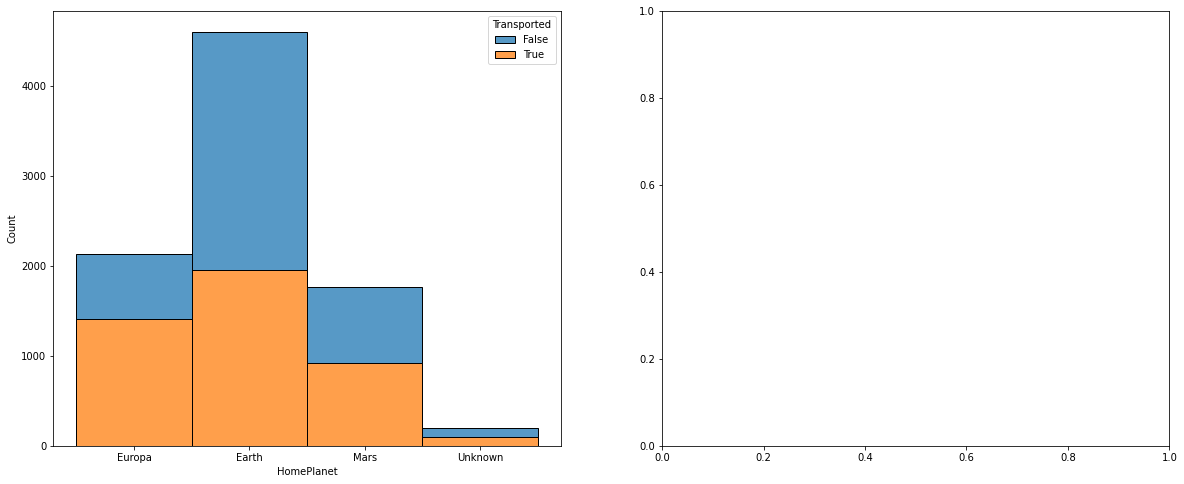

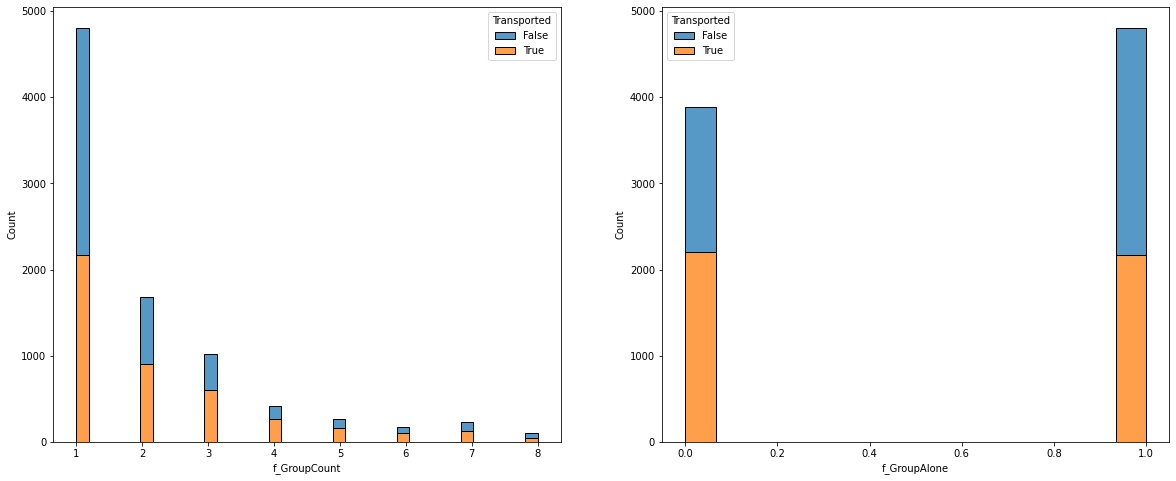

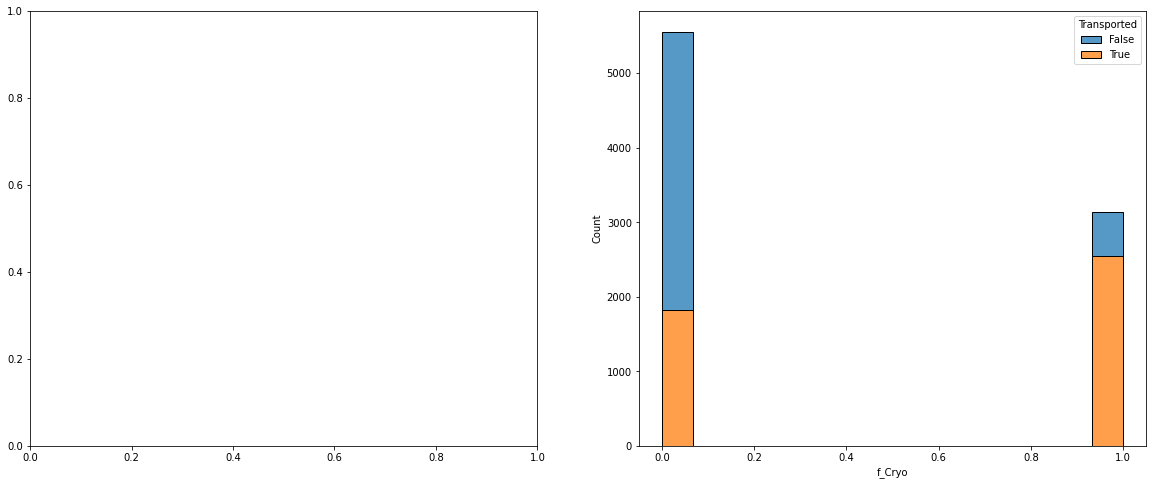

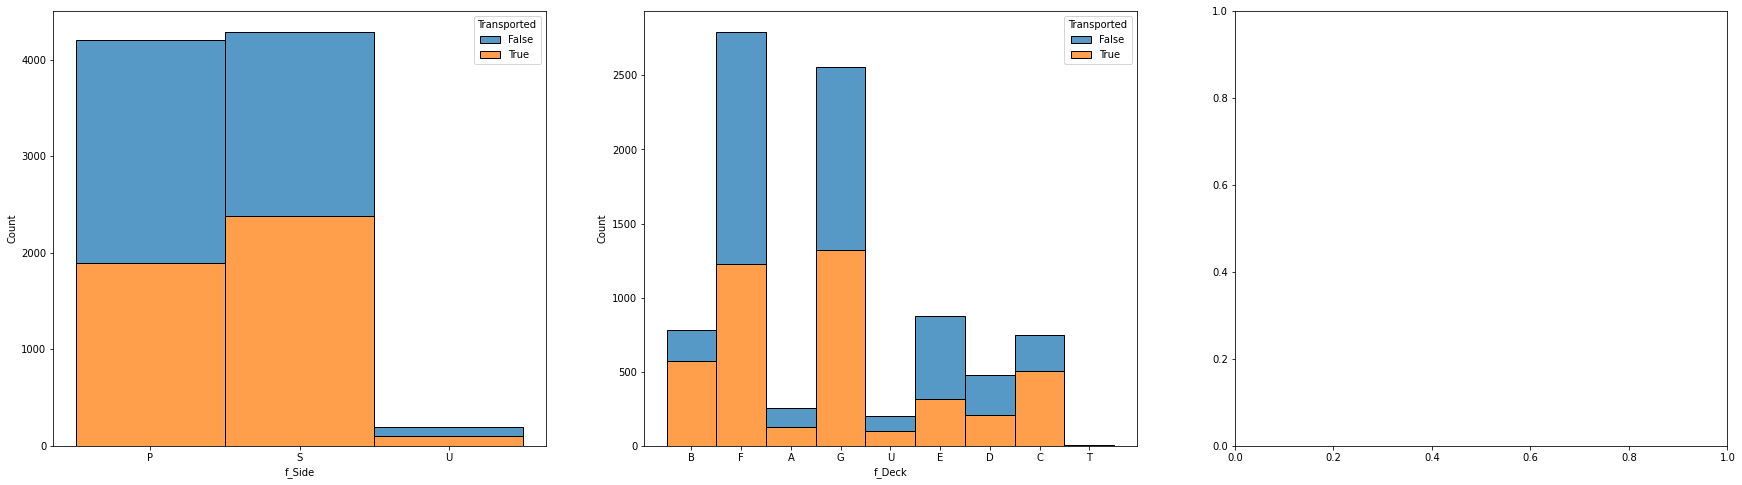

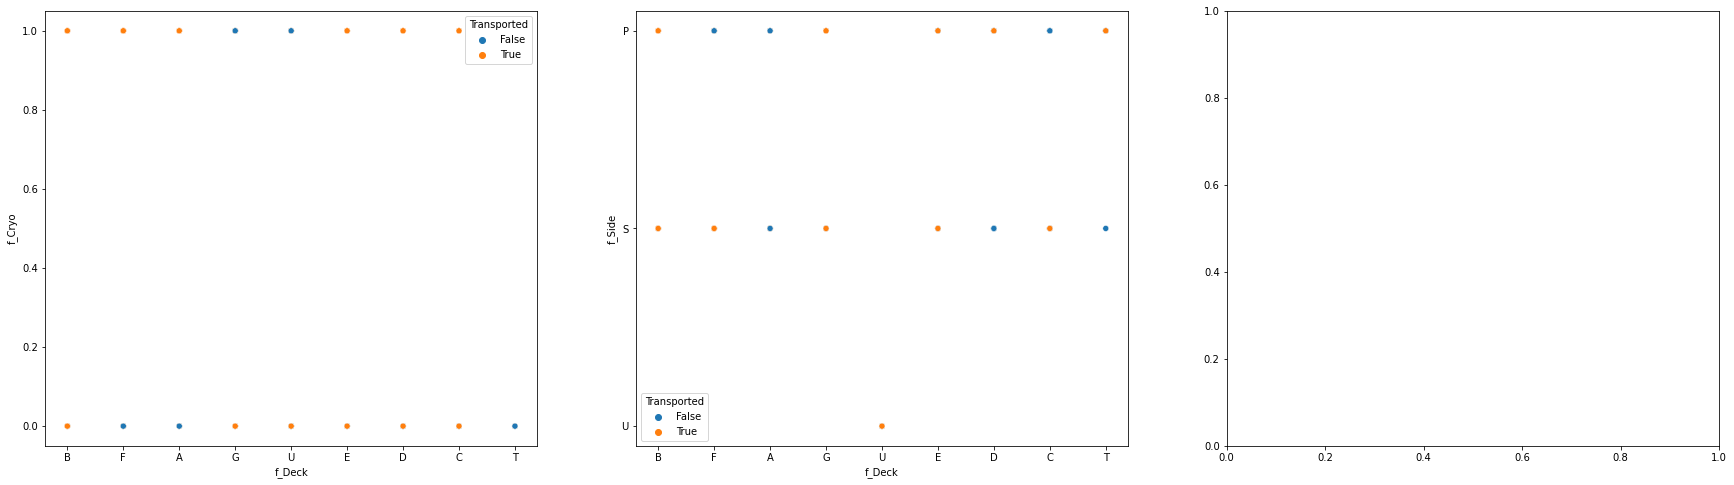

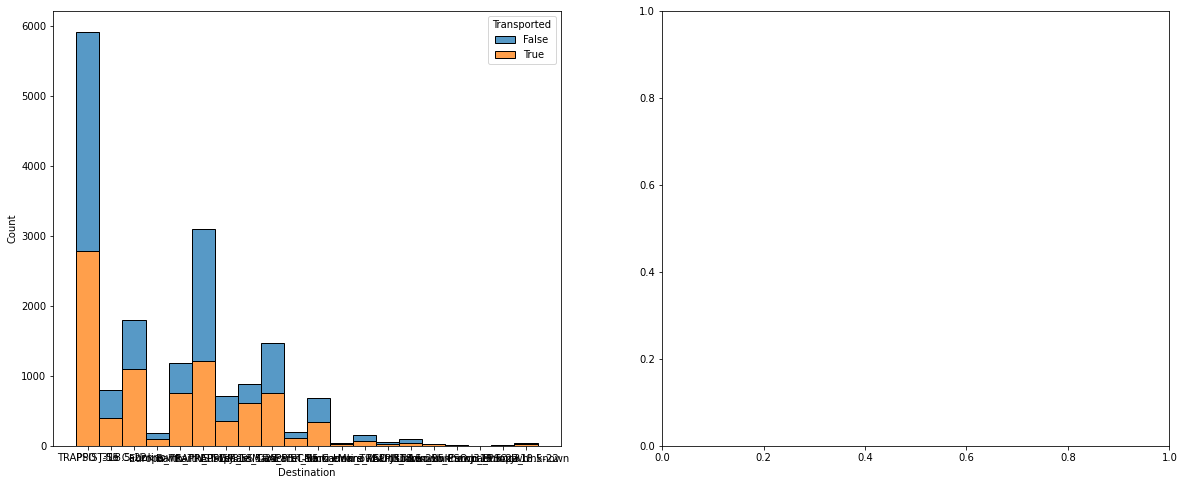

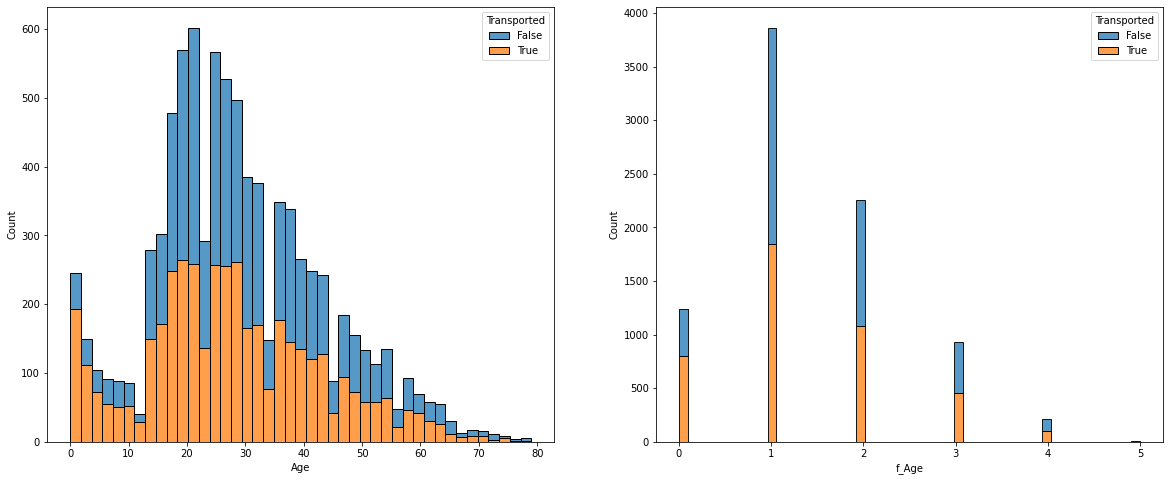

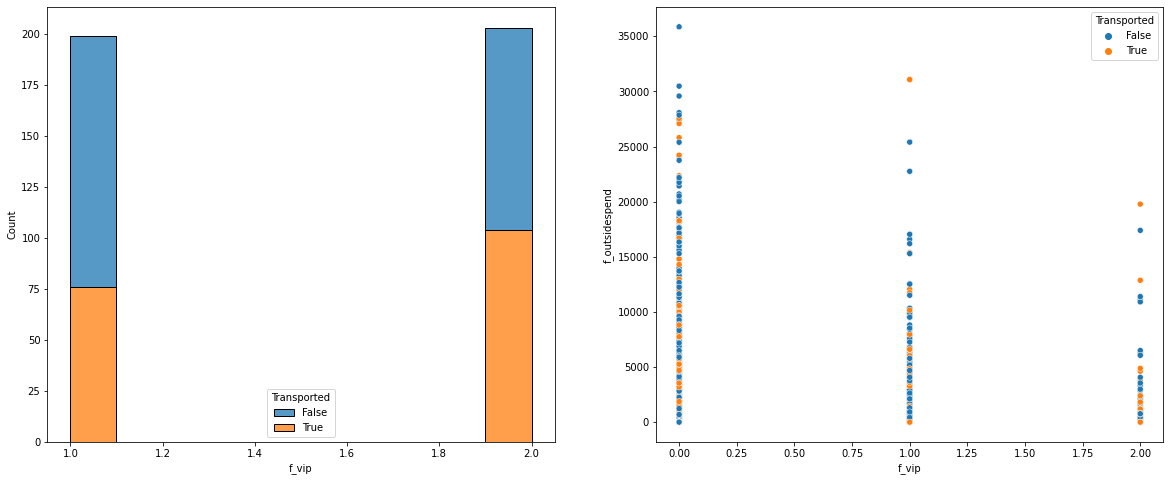

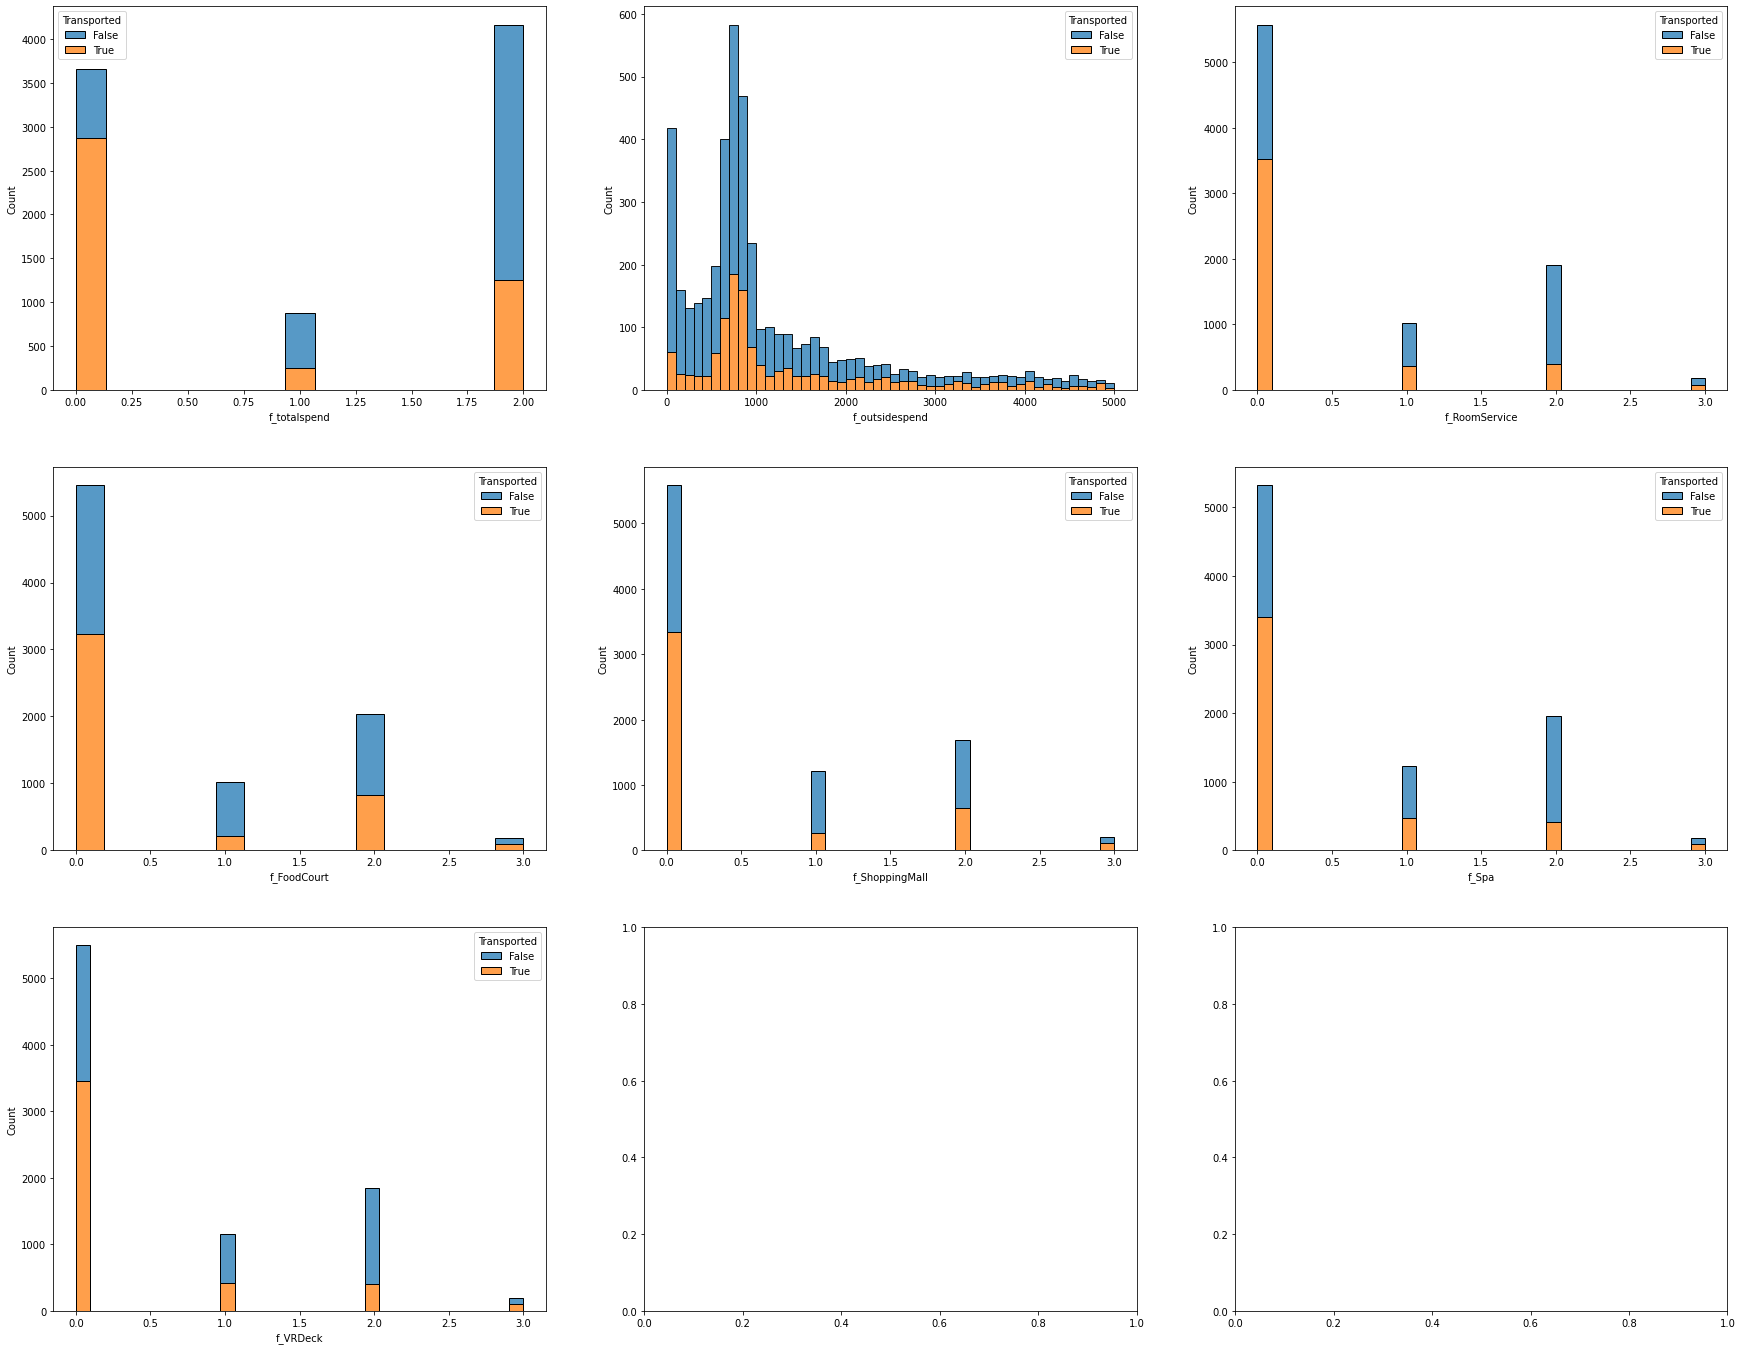

In [64]:
# Investigation

ppData = rawData.copy()

# Create features
ppData = create_features(ppData)

print(ppData.info())

fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data = ppData, x = "HomePlanet", ax=ax[0], hue = "Transported", multiple="stack")

# GroupId processing
fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data = ppData, x = "f_GroupCount", ax=ax[0], hue = "Transported", multiple="stack")
sns.histplot(data = ppData, x = "f_GroupAlone", ax=ax[1], hue = "Transported", multiple="stack")

# Cryo processing
fig, ax = plt.subplots(1, 2, figsize=(20,8))
#sns.histplot(data = ppData, x = "CryoSleep", ax=ax[0], hue = "Transported", multiple="stack")
sns.histplot(data = ppData, x = "f_Cryo", ax=ax[1], hue = "Transported", multiple="stack")

# Cabin processing
fig, ax = plt.subplots(1, 3, figsize=(30,8))
sns.histplot(data = ppData, x = "f_Side", ax=ax[0], hue = "Transported", multiple="stack")
sns.histplot(data = ppData, x = "f_Deck", ax=ax[1], hue = "Transported", multiple="stack")

# Cabin vs Cryo processing
fig, ax = plt.subplots(1, 3, figsize=(30,8))
sns.scatterplot(data = ppData, x = "f_Deck", y = "f_Cryo", hue = "Transported", ax = ax[0])
sns.scatterplot(data = ppData, x = "f_Deck", y = "f_Side", hue = "Transported", ax = ax[1])

# Destination processing
fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data = ppData, x = "Destination", ax=ax[0], hue = "Transported", multiple="stack")
sns.histplot(data = ppData, x = "f_HomeDest", ax=ax[0], hue = "Transported", multiple="stack")

# Age processing
fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data = ppData, x = "Age", ax=ax[0], hue = "Transported", multiple="stack")
sns.histplot(data = ppData, x = "f_Age", ax=ax[1], hue = "Transported", multiple="stack")

# VIP processing
fig, ax = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data = ppData, x = "f_vip", ax=ax[0], hue = "Transported", multiple="stack", binrange=[1,2])
sns.scatterplot(data = ppData, x = "f_vip", y = "f_outsidespend", hue = "Transported", ax = ax[1])

# Spend processing
fig, ax = plt.subplots(3, 3, figsize=(30,24))
sns.histplot(data = ppData, x = "f_totalspend", ax=ax[0, 0], hue = "Transported", multiple="stack")
sns.histplot(data = ppData, x = "f_outsidespend", ax=ax[0, 1], hue = "Transported", multiple="stack", bins=100, binrange=[1,5000], binwidth=100)
sns.histplot(data = ppData, x = "f_RoomService", ax=ax[0, 2], hue = "Transported", multiple="stack")
sns.histplot(data = ppData, x = "f_FoodCourt", ax=ax[1, 0], hue = "Transported", multiple="stack")
sns.histplot(data = ppData, x = "f_ShoppingMall", ax=ax[1, 1], hue = "Transported", multiple="stack")
sns.histplot(data = ppData, x = "f_Spa", ax=ax[1, 2], hue = "Transported", multiple="stack")
sns.histplot(data = ppData, x = "f_VRDeck", ax=ax[2, 0], hue = "Transported", multiple="stack")

# # Embaarked processing
# fig, ax = plt.subplots(1, 2, figsize=(20,8))
# sns.histplot(data = ppData, x = "Embarked", ax=ax[0], hue = "Survived", multiple="stack")
# sns.histplot(data = ppData, x = "f_Embarked", ax=ax[1], hue = "Survived", multiple="stack")



## Create and test models


In [69]:
# Create and test models

# Features to use
features = ["f_Cryo", "f_Deck_B", "f_Deck_E", "f_Deck_C", "f_Side_S", "f_ZeroSpend", "f_Young", "f_totalspend"]

# Create datasets
modelTrain = create_features(trainData)
modelTrain = modelTrain[features]

modelValidation = create_features(validationData)
modelValidation = modelValidation[features]

print(modelTrain.info())
print(modelValidation.info())

scores = []

scores = pd.DataFrame(score_models(modelTrain, modelValidation, trainTarget, validationTarget))

print(scores.loc[scores["type"] == "LinearSVC"].sort_values("accuracy", ascending=False))

scores.sort_values("accuracy", ascending=False)



<class 'pandas.core.frame.DataFrame'>
Index: 6954 entries, 3831_01 to 5515_01
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   f_Cryo        6954 non-null   int64  
 1   f_Deck_B      6954 non-null   uint8  
 2   f_Deck_E      6954 non-null   uint8  
 3   f_Deck_C      6954 non-null   uint8  
 4   f_Side_S      6954 non-null   uint8  
 5   f_ZeroSpend   6954 non-null   int64  
 6   f_Young       6954 non-null   int64  
 7   f_totalspend  6954 non-null   float64
dtypes: float64(1), int64(3), uint8(4)
memory usage: 298.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1739 entries, 3962_01 to 5974_01
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   f_Cryo        1739 non-null   int64  
 1   f_Deck_B      1739 non-null   uint8  
 2   f_Deck_E      1739 non-null   uint8  
 3   f_Deck_C      1739 non-null   uint8  
 4   f_Side_S      1739 

,type,mae,accuracy,estimators,depth
9,GradientBoostingClassifier,0.257044,0.742956,25.0,5.0
13,GradientBoostingClassifier,0.257044,0.742956,50.0,5.0
38,RandomForestClassifier,0.257619,0.742381,100.0,10.0
39,RandomForestClassifier,0.257619,0.742381,100.0,20.0
17,GradientBoostingClassifier,0.257619,0.742381,100.0,5.0
...,...,...,...,...,...
52,ExtraTreesClassifier,0.276596,0.723404,10.0,1.0
58,ExtraTreesClassifier,0.276596,0.723404,25.0,1.0
0,GradientBoostingClassifier,0.276596,0.723404,5.0,1.0
94,LinearSVC,0.277171,0.722829,NaN,NaN
